In [1]:
%cd ..

/home/alberto/PycharmProjects/incomplete_multiview_clustering


In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from imvc.datasets import LoadDataset
from imvc.decomposition import jNMF
from imvc.preprocessing import MultiViewTransformer
from imvc.ampute import Amputer
import pandas as pd

In [3]:
Xs = LoadDataset.load_dataset(dataset_name="nutrimouse")

In [4]:
n_components_list = [2, 4, 6, 8, 16, 32, 64]
errs = []
f_matrices = []
for n_components in n_components_list:
    pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                             jNMF(n_components = n_components, random_state=42).set_output(transform="pandas"))
    pipeline.fit(Xs)
    
    errs.append(pipeline[-1].reconstruction_err_[-1])
    f_matrices.append(pipeline[-1].H_)

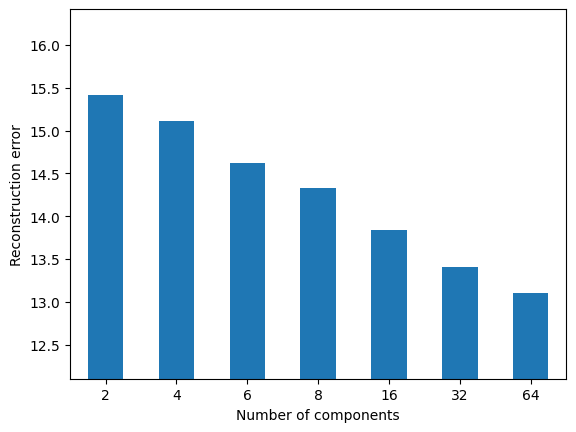

In [5]:
_ = pd.Series(errs, index= n_components_list).plot(kind= "bar", ylim= (min(errs) -1, max(errs) +1), ylabel= "Reconstruction error", xlabel= "Number of components", rot= 0)

In [6]:
f_matrices = pd.concat(f_matrices[3], axis= 0)

In [7]:
selected_features = {}
for col in f_matrices:
    selected_features[f_matrices[col].idxmax()] = f_matrices[col].max()
selected_features = pd.Series(selected_features).reset_index().sort_values(by=0, ascending= False)

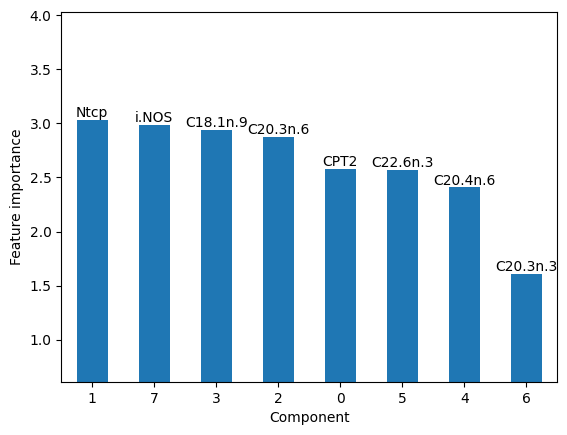

In [8]:
components_to_plot = selected_features[0]
ax = components_to_plot.plot(kind= "bar", ylim= (min(components_to_plot) -1, max(components_to_plot) +1),
                                                          ylabel= "Feature importance", xlabel= "Component", rot= 0)
_ = ax.bar_label(ax.containers[0], labels = selected_features["index"])

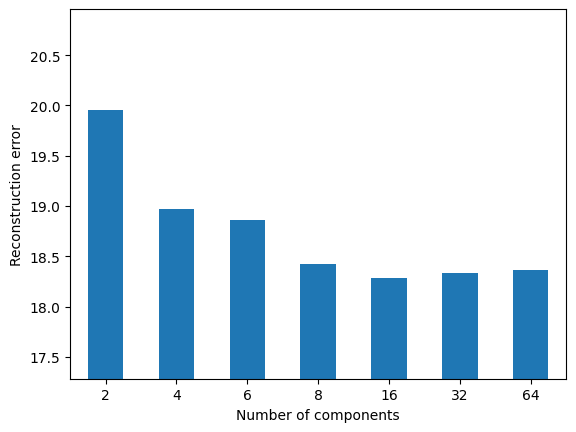

In [9]:
amputed_Xs = Amputer(p= 0.2, mechanism="MCAR", random_state=0).fit_transform(Xs)
n_components_list = [2, 4, 6, 8, 16, 32, 64]
errs = []
f_matrices = []
for n_components in n_components_list:
    pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                             jNMF(n_components = n_components, random_state=0).set_output(transform="pandas"))
    pipeline.fit(amputed_Xs)
    
    errs.append(pipeline[-1].reconstruction_err_[-1])

_ = pd.Series(errs, index= n_components_list).plot(kind= "bar", ylim= (min(errs) -1, max(errs) +1), ylabel= "Reconstruction error", xlabel= "Number of components", rot= 0)